# Recommender System with ALS & MF

**Author**: Dahye Kim 
**Last Edited**: 25 Apr 2021

This notebook recommends a list of items to each user given interaction history of users with existing items. Three models selected for the task - Matrix Factorisation Model (``mf``), Matrix Factorisation Model with Bias (`mf_b`), and Alternating Least Squares Model (`als`). Both matrix factorisation models are created using `torch` package, and the ALS model is created using `implicit` package. The structure of the notebook is as follow: 

* Loading the Data using `pandas`
* Configure MF Models
    * Matrix Factorisation Model 
    * Matrix Factorisation Model with Bias 
    * Training and Testing the MF Models
    * Evaluating Each Model using Validation Data set
* Configure ALS Models 
    * Tune Parameters of ALS Model using Validation Set and DCG
    * Fit the Model with the Best Parameters Combination
* Models Comparison 
* Obtain Predicted Rating from ALS Model 
    * Adjust Rating with Similarity to User's Preferred Item
* Recommend Items from Candidates

## Loading the Data

All data sets are loaded and inspected first using `pandas` library. 

In [1]:
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity 
import pandas as pd 
import numpy as np 
from scipy import stats 
import os 
import scipy.sparse as sparse
import implicit 
from sklearn.preprocessing import MinMaxScaler
from math import log
import torch
import torch.nn as nn
import torch.nn.functional as F
# torch library for MF models 

In [2]:
# assign each dataset in the list
test = pd.read_csv('flickr_test_data.csv')
train = pd.read_csv('flickr_train_data.csv')
valid = pd.read_csv('flickr_validation_data.csv')

In [3]:
user_df = pd.read_csv('flickr_user_fea.csv')
# the csv file with user's preferred item 
item_df = pd.read_csv('flickr_item_fea.csv')
# the csv file with the information on each item 
link_df = pd.read_csv('flickr_links.csv')

In [5]:
link_df.head()
# directed graph with weights on each edge

,src,des,weight
0,0,1431,1
1,0,955,1
2,0,1824,1
3,0,70,1
4,0,592,1


In [6]:
item_df.head()
# each item is represented as vector with the size of 257

,Unnamed: 0,fea_0,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,...,fea_246,fea_247,fea_248,fea_249,fea_250,fea_251,fea_252,fea_253,fea_254,fea_255
0,0,-1.360416,-0.683295,-0.659030,-1.840172,-1.875868,0.369852,-0.806902,-0.210944,-1.371679,...,-1.287771,-0.003345,-1.017979,-0.849153,-1.564582,-1.167882,-1.138140,-0.459417,-1.342706,-0.491899
1,1,-5.414928,-4.034106,-6.748904,-4.867840,-8.706087,-8.195160,-5.521785,-5.785634,-6.909437,...,-6.531560,-8.419637,-9.145112,-4.200750,-7.780539,-4.257525,-5.879356,-8.006350,-9.809999,-8.942007
2,2,-0.742383,-0.772285,-0.565367,-1.349759,-0.456425,-0.973115,-1.273366,-0.878384,-0.554383,...,-1.065703,-0.614035,-0.517165,-0.655323,-1.019581,-1.706855,-1.084116,-0.940970,-0.905574,-1.151560
3,3,-0.853681,-1.021450,-0.639012,-2.095687,-1.756671,-0.450270,-0.607497,-0.755120,-0.827463,...,-1.223609,-1.181383,-0.928340,-0.841091,-1.477898,-1.802510,-1.177191,-1.632113,-1.980912,-1.298478
4,4,-1.049173,-0.208819,-1.020380,-1.916308,-1.213041,0.404414,-1.085374,-1.219756,-0.854078,...,-1.427951,-0.035228,-0.856884,-1.142188,-1.742321,-0.767455,0.114727,-0.083121,-1.886625,-0.243228


In [7]:
user_df.head()

,Unnamed: 0,fea_0,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,...,fea_246,fea_247,fea_248,fea_249,fea_250,fea_251,fea_252,fea_253,fea_254,fea_255
0,0,-1.238114,-1.020155,-1.370791,-1.892076,-1.615505,-1.056106,-1.260189,-1.537514,-1.279543,...,-1.639152,-1.351084,-1.526210,-1.441551,-1.567562,-1.363613,-1.133677,-1.448653,-1.912987,-1.220462
1,1,-1.142714,-1.012310,-1.109844,-1.806807,-1.533666,-0.894846,-1.360289,-1.159866,-1.184760,...,-1.471417,-1.028792,-1.397979,-1.304754,-1.630009,-1.318048,-1.080598,-1.251735,-1.813930,-0.975978
2,2,-1.698521,-1.605196,-1.328976,-1.492204,-1.541542,-1.155632,-1.297039,-1.485625,-1.348223,...,-1.529016,-1.372415,-1.769800,-1.414428,-1.550462,-1.249593,-1.284915,-1.446422,-1.686583,-1.145916
3,3,-1.328761,-1.267363,-1.243220,-1.721551,-1.182082,-1.320123,-1.115170,-1.122703,-1.140961,...,-1.441997,-0.956042,-1.570591,-1.238835,-1.489867,-1.320204,-1.202990,-1.322884,-1.580290,-0.931394
4,4,-1.132466,-1.026957,-1.019664,-1.649181,-1.382753,-0.776261,-1.221357,-1.061034,-1.041313,...,-1.307160,-0.940088,-1.313026,-1.308773,-1.455208,-1.056440,-0.950118,-1.029165,-1.593675,-0.886145


### Checking the Duplicates 

In [8]:
train_test_duplicate = pd.merge(train.drop('rating', axis = 1), test, \
             on = ['user_id', 'item_id'], \
         how = 'right', indicator = 'Exist')
# right merge the train data to test data on user_id and item_id 
# indicator = 'Exist' indicates whether the entry is on the left, right, or both 
# If an entry in train set exists in the test set 'Exist' should return 'both'

pd.unique(train_test_duplicate.Exist)
# 'Exist' only returned 'right_only'
# this indicates no rows from train df is observed in test set 

['right_only']
Categories (1, object): ['right_only']

In [9]:
valid_test_duplicate = pd.merge(valid, test, \
                                on = ['user_id', 'item_id'], \
                                how = 'right', \
                                indicator = 'Exist')
# right merge the valid data to test data on user_id and item_id 
# indicator = 'Exist' indicates whether the entry is on the left, right, or both 
# If an entry in train set exists in the test set 'Exist' should return 'both'
pd.unique(valid_test_duplicate.Exist)
# Exist == 'both' indicates that some entries in valid exists in test set 


['right_only', 'both']
Categories (2, object): ['right_only', 'both']

In [10]:
pd.unique(valid_test_duplicate[valid_test_duplicate.Exist == 'both'].rating)
# the entries existing in both valid and test sets all have rating of 0 
# no previous interaction of item and user in test set observed 

array([0.])

In [11]:
train[train.duplicated(keep = False)]
# no duplicates observed in train set 

,user_id,item_id,rating


In [12]:
test[test.duplicated(keep = False)]
# duplicates observed from test set
# the duplicate rows do not contribute to the prediction of recommendations 
# duplicate rows will thus be removed 

,user_id,item_id
110,1,8131
111,1,8131
219,2,6950
220,2,6950
440,4,4999
...,...,...
345838,3458,4645
345921,3459,6969
345922,3459,6969
346451,3464,4448


In [13]:
valid[valid.duplicated(keep = False)]
# duplicates observed from valid set
# duplicate rows will be removed 

,user_id,item_id,rating
129,1,1897,0
143,1,6215,0
158,1,1897,0
187,1,6215,0
406,4,1324,0
...,...,...,...
346458,3464,5064,0
346477,3464,4597,0
346497,3464,4597,0
346556,3465,349,0


In [16]:
valid.drop(valid[valid.duplicated()].index, inplace = True)
valid.reset_index(drop= True, inplace = True)

In [17]:
test.drop(test[test.duplicated()].index, inplace = True)
test.reset_index(drop= True, inplace = True)
valid.drop(valid[valid.duplicated()].index, inplace = True)
valid.reset_index(drop= True, inplace = True)
# remove the duplicated rows by obtaining the index 
# reset the data frame index after removing rows 

## Model Configuration

### Matrix Factorisation

In [18]:
class MF(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100):
        super(MF, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        # embed users and item vectors
        # users embedding has size of user_id x emb_size
        # items embedding has size of item_id x emb_size
        self.user_emb.weight.data.uniform_(0, 0.05)
        self.item_emb.weight.data.uniform_(0, 0.05)
        
    def forward(self, u, v):
        u = self.user_emb(u)
        v = self.item_emb(v)
        # predict item*user matrix with ratings using matrix factorisation
        return (u*v).sum(1)   

### Matrix Factorisation with Bias

In [19]:
class MF_bias(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100):
        super(MF_bias, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.item_bias = nn.Embedding(num_items, 1)
        # embed users and item vectors
        # users embedding has size of user_id x emb_size
        # items embedding has size of item_id x emb_size
        # add bias by dropping number of parameters
        self.user_emb.weight.data.uniform_(0,0.05)
        self.item_emb.weight.data.uniform_(0,0.05)
        self.user_bias.weight.data.uniform_(-0.01,0.01)
        self.item_bias.weight.data.uniform_(-0.01,0.01)
        
    def forward(self, u, v):
        U = self.user_emb(u)
        V = self.item_emb(v)
        b_u = self.user_bias(u).squeeze()
        b_v = self.item_bias(v).squeeze()
        return (U*V).sum(1) +  b_u  + b_v

### Training and Testing Matrix Factorisation Models

In [20]:
def train_epocs(model, epochs=10, lr=0.01, wd=0.0, unsqueeze=False):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    # optimise the MF models using Adam optimiser
    model.train()
    # set torch to train mode 
    
    for i in range(epochs):
        
        users = torch.LongTensor(train.user_id.values)
        items = torch.LongTensor(train.item_id.values)
        ratings = torch.FloatTensor(train.rating.values)
        # convert each attribute to tensor 
        
        if unsqueeze:
            ratings = ratings.unsqueeze(1)
            # squeeze ratings to one-dimensional tensor
            
        y_hat = model(users, items)
        # predict the rating using user and item tensors
        
        loss = F.mse_loss(y_hat, ratings)
        # calculate the loss using MSE
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    test_loss(model, unsqueeze)

In [21]:
def test_loss(model, unsqueeze=False):
    model.eval()
    # set torch to evaluation mode
    users = torch.LongTensor(train.user_id.values)
    items = torch.LongTensor(train.item_id.values)
    ratings = torch.FloatTensor(train.rating.values)
    # convert all user, item, and ratings to tensors 
    if unsqueeze:
        ratings = ratings.unsqueeze(1)
    y_hat = model(users, items)
    loss = F.mse_loss(y_hat, ratings)
    # predict the ratings and calculate the loss using MSE
    print("test loss %.3f " % loss.item())

In [22]:
def predict(model, df): 
    
    model.eval()
    # set torch to evaluation mode 
    
    with torch.no_grad(): 
        users = torch.LongTensor(df.user_id.values)
        items = torch.LongTensor(df.item_id.values) 
        y_hat = model(users, items)
        # make prediction using user and item tensors 
            
    return y_hat
    # return the predicted ratings 

In [23]:
num_users = len(pd.unique(train.user_id))
num_items = len(pd.unique(train.item_id))
# determine the input dimension to MF models
# input dimension of all the MF models is the number of user_id and item_id

## Evaluation of MF Models with Validation Set

In [24]:
emb = [*range(5,100,15)]
lr = [0.001, 0.005, 0.01, 0.025, 0.05]
epc = [*range(10,30,5)]

In [25]:
mf_b_hp = dict()
mf_hp = dict()

for e in emb: 
    
    mf_b = MF_bias(num_users, num_items, e)
    mf = MF(num_users, num_items, e)
    
    for l in lr:
        for ep in epc: 
            
            train_epocs(mf_b, epochs=ep, lr=l)
            train_epocs(mf, epochs=ep, lr=l)
            
            valid['mf_bias_predicted'] = predict(mf_b, valid)
            valid['mf_predicted'] = predict(mf, valid)
            
            validrank_mf_b = valid\
            .sort_values(by = ['user_id', 'mf_bias_predicted'], ascending=False)\
            .groupby('user_id').head(15).reset_index(drop = True)
            
            validrank_mf = valid\
            .sort_values(by = ['user_id', 'mf_predicted'], ascending=False)\
            .groupby('user_id').head(15).reset_index(drop = True)

            validrank_mf_b['rank'] = [*range(1,16)]*num_users
            validrank_mf['rank'] = [*range(1,16)]*num_users
            
            mf_bias_dcg = validrank_mf_b[validrank_mf_b.rating == 1]['rank']\
            .apply(lambda x: 1/log(x+1)).sum()
            mf_dcg = validrank_mf[validrank_mf.rating == 1]['rank']\
            .apply(lambda x: 1/log(x+1)).sum()
            
            mf_b_hp[f'em_{e}_lr_{l}_ep_{ep}'] = mf_bias_dcg
            mf_hp[f'em_{e}_lr_{l}_ep_{ep}'] = mf_dcg
            
            print(f'em_{e}_lr_{l}_ep_{ep}\n')

test loss 0.949 
test loss 0.988 
em_5_lr_0.001_ep_10

test loss 0.879 
test loss 0.975 
em_5_lr_0.001_ep_15

test loss 0.784 
test loss 0.951 
em_5_lr_0.001_ep_20

test loss 0.664 
test loss 0.910 
em_5_lr_0.001_ep_25

test loss 0.429 
test loss 0.797 
em_5_lr_0.005_ep_10

test loss 0.138 
test loss 0.566 
em_5_lr_0.005_ep_15

test loss 0.001 
test loss 0.231 
em_5_lr_0.005_ep_20

test loss 0.000 
test loss 0.003 
em_5_lr_0.005_ep_25

test loss 0.000 
test loss 0.000 
em_5_lr_0.01_ep_10

test loss 0.000 
test loss 0.000 
em_5_lr_0.01_ep_15

test loss 0.000 
test loss 0.000 
em_5_lr_0.01_ep_20

test loss 0.000 
test loss 0.000 
em_5_lr_0.01_ep_25

test loss 0.004 
test loss 0.002 
em_5_lr_0.025_ep_10

test loss 0.000 
test loss 0.000 
em_5_lr_0.025_ep_15

test loss 0.001 
test loss 0.001 
em_5_lr_0.025_ep_20

test loss 0.001 
test loss 0.000 
em_5_lr_0.025_ep_25

test loss 0.014 
test loss 0.007 
em_5_lr_0.05_ep_10

test loss 0.002 
test loss 0.000 
em_5_lr_0.05_ep_15

test loss 0.001 

In [26]:
params_mf_b = list(mf_b_hp.keys())
params_mf_b_dcg = [mf_b_hp[i] for i in params_mf_b]
params_mf_dcg = [mf_hp[i] for i in params_mf_b]

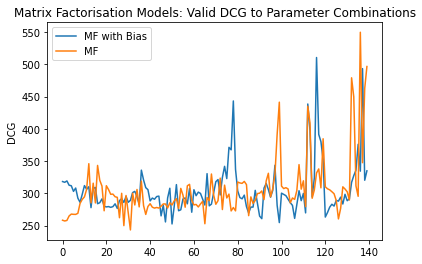

In [27]:
from matplotlib import pyplot as plt
plt.plot([*range(len(params_mf_b))], params_mf_b_dcg, label = 'MF with Bias')
plt.plot(params_mf_dcg, label = 'MF')
plt.title('Matrix Factorisation Models: Valid DCG to Parameter Combinations')
plt.ylabel('DCG')
plt.legend(loc = 'upper left');

In [28]:
pd.DataFrame({'params':params_mf_b,'mf_b_dcg':params_mf_b_dcg})\
.sort_values('mf_b_dcg', ascending=True).tail()

,params,mf_b_dcg
113,em_80_lr_0.025_ep_15,398.308418
112,em_80_lr_0.025_ep_10,438.504961
78,em_50_lr_0.05_ep_20,443.232429
137,em_95_lr_0.05_ep_15,493.399656
116,em_80_lr_0.05_ep_10,510.605334


In [29]:
pd.DataFrame({'params':params_mf_b,'mf_dcg':params_mf_dcg})\
.sort_values('mf_dcg', ascending=True).tail()

,params,mf_dcg
133,em_95_lr_0.025_ep_15,449.578163
138,em_95_lr_0.05_ep_20,462.686076
132,em_95_lr_0.025_ep_10,479.148402
139,em_95_lr_0.05_ep_25,496.628378
136,em_95_lr_0.05_ep_10,549.809805


## ALS Model with ``implicit`` pkg - Parameter Tuning

In [30]:
item_user_train = sparse.csr_matrix((train.rating.astype(float),\
                                    (train.item_id, train.user_id)))
user_item_train = sparse.csr_matrix((train.rating.astype(float),\
                                    (train.user_id, train.item_id)))
# convert the train data into sparse matrix 

In [32]:
factor_tuning = dict()
# DCG of model with each parameter combination 

for alpha in range(2,100,5):
# first parameter for tuning - alpha
# Range of alpha is between 2 and 100, 5 steps each 
    
    adjustedData = (item_user_train*alpha).astype('double')
    # apply the alpha confidence level of current loop 
    
    for factor in range(2,50,5):
    # second parameter for tunining - factor 
    # matrix factor for user & item matrices

        model = implicit.als.AlternatingLeastSquares(factors = factor,\
                                                regularization = 0.1,\
                                                iterations = 50)
        # configure the model using the parameters in current loop 
        model.fit(adjustedData, show_progress = False)
        # fit the model, omit the progress bar
        
        als_dcg = 0
        # initialise the dcg of the model 
        
        for i in pd.unique(valid.user_id): 
        # for each user

            userDF = valid[valid.user_id == i] 
            # obtain the valid data set with the user ID in current loop

            itemsCandidates = userDF['item_id'].astype(int).tolist()
            # the list of all the candidate items in valid datset
            topItem = int(userDF[userDF.rating == 1]['item_id'])
            # the item_id of item with rating == 1

            rankList = model.rank_items(userid=i, user_items = user_item_train,\
                        selected_items = itemsCandidates)
            # get the rank from ALS model of all the items from itemCandidates 

            top15_rank = list(map(lambda x: x[0], rankList))[1:15]
            # obtain the top 15 items with the best score 

            if topItem in top15_rank: 
            # if the item with rating == 1 is present in predicted rank from the model 
                idx = top15_rank.index(topItem)+1
                # obtain the rank of that item 
                als_dcg += 1/log(idx+1)
                # calculate the dcg score
                factor_tuning[f'a_{alpha}_f_{factor}'] = als_dcg
                # record the respective dcg score of each model
                
        print(f'a_{alpha}_f_{factor}')

a_2_f_2
a_2_f_7
a_2_f_12
a_2_f_17
a_2_f_22
a_2_f_27
a_2_f_32
a_2_f_37
a_2_f_42
a_2_f_47
a_7_f_2
a_7_f_7
a_7_f_12
a_7_f_17
a_7_f_22
a_7_f_27
a_7_f_32
a_7_f_37
a_7_f_42
a_7_f_47
a_12_f_2
a_12_f_7
a_12_f_12
a_12_f_17
a_12_f_22
a_12_f_27
a_12_f_32
a_12_f_37
a_12_f_42
a_12_f_47
a_17_f_2
a_17_f_7
a_17_f_12
a_17_f_17
a_17_f_22
a_17_f_27
a_17_f_32
a_17_f_37
a_17_f_42
a_17_f_47
a_22_f_2
a_22_f_7
a_22_f_12
a_22_f_17
a_22_f_22
a_22_f_27
a_22_f_32
a_22_f_37
a_22_f_42
a_22_f_47
a_27_f_2
a_27_f_7
a_27_f_12
a_27_f_17
a_27_f_22
a_27_f_27
a_27_f_32
a_27_f_37
a_27_f_42
a_27_f_47
a_32_f_2
a_32_f_7
a_32_f_12
a_32_f_17
a_32_f_22
a_32_f_27
a_32_f_32
a_32_f_37
a_32_f_42
a_32_f_47
a_37_f_2
a_37_f_7
a_37_f_12
a_37_f_17
a_37_f_22
a_37_f_27
a_37_f_32
a_37_f_37
a_37_f_42
a_37_f_47
a_42_f_2
a_42_f_7
a_42_f_12
a_42_f_17
a_42_f_22
a_42_f_27
a_42_f_32
a_42_f_37
a_42_f_42
a_42_f_47
a_47_f_2
a_47_f_7
a_47_f_12
a_47_f_17
a_47_f_22
a_47_f_27
a_47_f_32
a_47_f_37
a_47_f_42
a_47_f_47
a_52_f_2
a_52_f_7
a_52_f_12
a_52_f_17
a_

In [34]:
params = list(factor_tuning.keys())
params_dcg = [factor_tuning[i] for i in params]
# obtain the parameter combinations and respective dcg scores

pd.DataFrame({'params':params, 'als_dcg':params_dcg})\
.sort_values('als_dcg').tail()
# the parameter combinations with the highest dcg scores

,params,als_dcg
121,a_62_f_7,894.753698
191,a_97_f_7,897.913231
171,a_87_f_7,898.683967
52,a_27_f_12,904.403467
141,a_72_f_7,908.376011


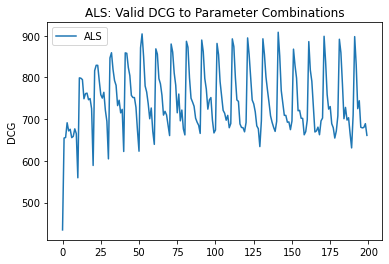

In [35]:
from matplotlib import pyplot as plt
plt.plot([*range(len(params_dcg))], params_dcg, label = 'ALS')
plt.title('ALS: Valid DCG to Parameter Combinations')
plt.ylabel('DCG')
plt.legend(loc = 'upper left');

## Model Fitting and Comparison

In [36]:
alpha = 72
# confidence level parameter

adjustedData = (item_user_train*alpha).astype('double')
# adjust the sparse matrix using alpha = 57

model = implicit.als.AlternatingLeastSquares(factors = 7,\
                                            regularization = 0.1,\
                                            iterations = 50)
# build ALS model with matrix factor of 7 and lambda of 0.1

model.fit(adjustedData)

In [37]:
als_dcg = 0

for i in pd.unique(valid.user_id): 
# for each user
    
    userDF = valid[valid.user_id == i] 
    # obtain the valid data set with the user ID in current loop
    
    itemsCandidates = userDF['item_id'].astype(int).tolist()
    # the list of all the candidate items in valid datset
    topItem = int(userDF[userDF.rating == 1]['item_id'])
    # the item_id of item with rating == 1
    
    rankList = model.rank_items(userid=i, user_items = user_item_train,\
                selected_items = itemsCandidates)
    # get the rank from ALS model of all the items from itemCandidates 
    
    top15_rank = list(map(lambda x: x[0], rankList))[1:15]
    # obtain the top 15 items with the best score 
    
    if topItem in top15_rank: 
    # if the item with rating == 1 is present in predicted rank from the model 
        idx = top15_rank.index(topItem)+1
        # obtain the rank of that item 
        als_dcg += 1/log(idx+1)
        # calculate the dcg score

print(f'DCG for the Final Model: {als_dcg}')

DCG for the Final Model: 891.3780215779744


## Obtain Predicted Rating from ALS Model 

In [38]:
test['rating'] = 0

for i in pd.unique(test.user_id): 
# for each user
    
    userDF = test[test.user_id == i] 
    # obtain the valid data set with the user ID in current loop
    
    itemsCandidates = userDF['item_id'].astype(int).tolist()
    # the list of all the candidate items in valid datset
    
    rankedList = model.rank_items(userid=i, \
                                  user_items = user_item_train,\
                selected_items = itemsCandidates)
    # get the rank from ALS model of all the items from itemCandidates
    
    predRatings = list(map(lambda x: x[1], rankedList))
    # predicted rating of each item of each user into a list
    rankedItems = list(map(lambda x: x[0], rankedList))
    # respective item sorted based on scores into a list
    
    test['item_id'][test.user_id == i] = rankedItems
    test['rating'][test.user_id == i] = predRatings
    # record the item ID and predicted scores from the ALS model 
    

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id'][test.user_id == i] = rankedItems
<ipython-input-38-3c22d155273f>:22: SettingWit

## Adjust Rating with Similarity to User's Preferred Item

In [39]:
user_ = np.asarray(user_df.iloc[:,1:])
item_ = np.asarray(item_df.iloc[:,1:])
# convert the preferred item from each user to numpy array of vectors 
# convert the vector representation of each item to numpy array of vectors

sim = MinMaxScaler().fit_transform(cosine_similarity(user_, item_))
# calculate the similarity of each item and the preferred item of users 


In [40]:
test['adjusted'] = test.apply(lambda x: \
                              sim[int(x['user_id']), int(x['item_id'])] + \
                              float(x['rating']), \
                              axis = 1)

In [45]:
test.sort_values('adjusted', ascending = False).head(10)

,user_id,item_id,rating,adjusted
173148,1741,2865,1.528013,2.425353
257695,2591,1253,1.573679,2.418272
317649,3194,207,1.395983,2.237750
289303,2909,2195,1.360359,2.225541
185986,1870,561,1.375450,2.204108
185985,1870,49,1.487144,2.189780
29341,295,3990,1.522202,2.181944
173149,1741,1948,1.485427,2.179312
239784,2411,872,1.255958,2.149874
77887,783,49,1.324673,2.149029


## Recommend Items from Candidate Items

In [46]:
def recommend(userID, test_user_item, person_vecs, content_vecs, num = 15):
    
    interaction = test_user_item[userID,:].toarray().reshape(-1)
    # interaction is the predicted rating from ALS model
    recVec_ = person_vecs[userID,:].dot(content_vecs.T).toarray().reshape(-1,1)
    # Dot product the user embedding and item embedding 
    
    recVecScaled = MinMaxScaler().fit_transform(recVec_)[:,0]
    # scale the dot product of user and item embeddings with MinMaxScaler
    recVec = interaction*recVecScaled 
    # all the items with the element of 1 will be multiplied with the probablities
    # the items will be then recommended based on the ranking 
    
    contentIdx = np.argsort(recVec)[::-1][:num]
    # sort the indices fo the content into order of best recommendations 
    
    users, item_id = [],[]

    for idx in contentIdx:
        
        item_id.append(int(test.item_id.loc[test.item_id == idx].iloc[0]))
        users.append(int(userID))
        # Append item_id and replicated user_id to the lists

    return (users, item_id)

In [47]:
test_user_item = sparse.csr_matrix((test['adjusted'].astype(float), \
                                         (test['user_id'], test['item_id'])))

In [48]:
person_vecs = sparse.csr_matrix(model.user_factors)
content_vecs = sparse.csr_matrix(model.item_factors)
# obtain user and item embeddings from the ALS model 

In [49]:
solution = pd.DataFrame(columns = ['user_id', 'item_id'],\
                       index = 15*[*range(max(test.user_id)+1)])
# empty data frame to record top-15 recommended item of each user

In [50]:
n = 0
for i in pd.unique(test.user_id):
    userID, itemID = recommend(i, test_user_item, person_vecs, content_vecs)
    # recommend function returns the list of user_id and item_id
    # itemID has the top-15 recommended items 
    # userID has the replicated list of user_ids
    solution.iloc[n*15:n*15+15,0] = userID
    solution.iloc[n*15:n*15+15,1] = itemID
    # fill in the solution dataframe
    n+=1